## Import Statements + Definitions

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

#### Electron class
Stores history of x values, y values and velocities.

In [2]:
class electron:
    def __init__(self):
        self.x = []
        self.y = []
        self.v = []

#### Creation of grid
For the purposes of this, we will be working on a 50 by 50 lattice of cations of charge +1. This means that there are 2500 electrons. Also, we will be assuming that this models a closed circuit with electric field upwards, so when an electron exits out the top it will be transported back to the bottom. This is a reasonable assumption, as the electrons are independent and we only need their velocities, not their positions, to calculate the current density. The electrons are also contained between the left and right walls of the grid.

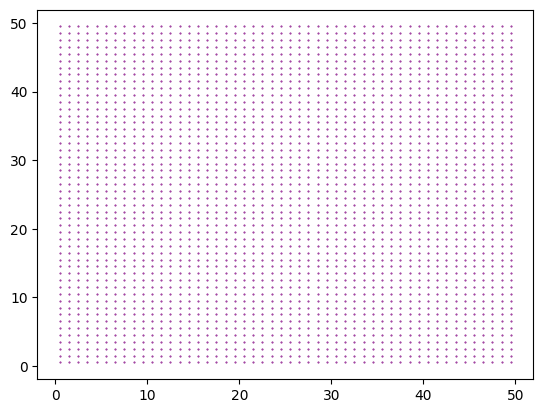

In [3]:
grid_x = 50 # Defining matrix of cations
grid_y = 50
vel = np.array([np.random.randint(1.0), np.random.randint(1.0)]) # velocity of electron

x, y = np.meshgrid(np.arange(0.5, grid_x+0.5, 1), np.arange(0.5, grid_y+0.5, 1))
plt.scatter(x, y, color='purple', s=0.2)


#### Initialise an electron's position and velocity
The electron is set to have a random velocity where both x and y components have magnitude $\leq 1$. This is to comply with the assumptions given by the Drude model, although it should not matter much in the end.

In [22]:
def get_x0_and_v0():
    x0 = np.random.randint(grid_x)
    v0 = np.array([np.random.uniform(-1, 1), np.random.uniform(-1, 1)])
    return [x0, v0]

#### Define the function that calculates the closest cation
Later, this distance will be compared with the radius of the cation to determine whether a collision has occurred.

In [5]:
def get_min_distance(pos):
    x_diff = (pos[0])%1-0.5
    y_diff = (pos[1])%1-0.5
    sqdist = x_diff**2 + y_diff**2
    return [x_diff, y_diff, sqdist]

#### Main simulation
We produce 2500 electrons (which many change when we vary grid size), and then simulate them with an electric field. The changing variables are the electric field strength, the radius of the cations and the coefficient of restitution. Then we run it for 2000 frames.

In [17]:
frames = 2000

def run_sim(acc, r, cor):
    electrons = [electron() for i in range(grid_x * grid_y)]
    def assign_start(n):
        for i in n:
            i.x.append(get_x0_and_v0()[0])
            i.y.append(0)
            i.v.append(get_x0_and_v0()[1])

    assign_start(electrons)


    for i in tqdm(electrons):
        counter = 1
        while counter < frames:
            i.y[-1] = ((i.y[-1] % grid_y) + grid_y) % grid_y
            d = get_min_distance([i.x[-1], i.y[-1]])
            if (0 < d[2] < r**2):
                diff = np.array([d[0],d[1]])
                i.v.append(i.v[-1] - (1+cor) * ((np.dot(i.v[-1], diff))/(d[2]) * diff))
            elif i.x[-1] > grid_x or i.x[-1] < 0:
                i.v.append(np.array(-i.v[-1][0],i.v[-1][1]) + acc * 0.1)
            else:
                i.v.append(i.v[-1] + acc * 0.1)
            i.x.append(i.x[-1] + i.v[-1][0]*0.1)
            i.y.append(i.y[-1] + i.v[-1][1]*0.1)
            counter = counter + 1
    return electrons

#### Calculating the average velocity
The average velocity may be calculated by taking all of the electron's velocity at the end of 2000 frames and taking the mean. However, this runs into issues as we can see below.

In [18]:
def bad_avg_v(n):
    tmp = []
    for i in n:
        tmp.append(i.v[-1][1])
    return sum(tmp) / len(tmp)

def avg_v(n):
    tmp = []
    for i in n:
        tmp.append(i.v[-1][1])
    lower_5 = np.percentile(tmp,5)
    upper_5 = np.percentile(tmp,95)
    tmp2 = []
    for i in n:
        if lower_5 <= i.v[-1][1] and upper_5 >= i.v[-1][1]: # Prune upper and lower 5%. This is because certain electrons can go really fast if they do not come into contact with a cation for a long time. This happens due to large acceleration and/or small coefficient of restitution.
            tmp2.append(i.v[-1][1])
    return sum(tmp2) / len(tmp2)

In [27]:
bad_vs = []
vs = []
accs = np.linspace(0.0, 5.0, 11)
sims = []

for i in tqdm(accs):
    sims.append(run_sim(np.array([0, i]), 0.2, 0.9))

for sim in tqdm(sims):
    vs.append(avg_v(sim))
    bad_vs.append(bad_avg_v(sim))

100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


R^2 value: 0.7326402413648536


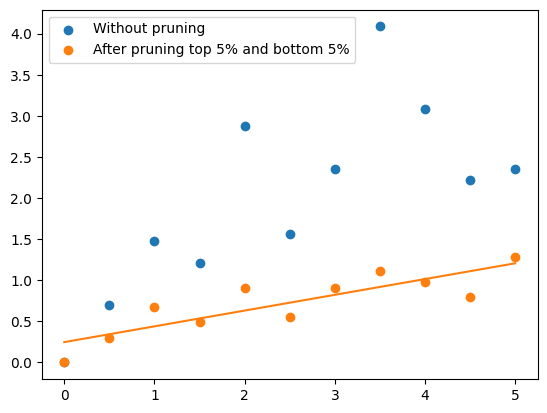

In [32]:
plt.scatter(accs, bad_vs)
plt.scatter(accs, vs)
plt.legend(["Without pruning", "After pruning top 5% and bottom 5%"])
plt.plot([])
plt.plot(accs, accs * scipy.stats.linregress(accs,vs).slope + scipy.stats.linregress(accs,vs).intercept)
print(f"R^2 value: {scipy.stats.linregress(accs,vs).rvalue**2}")

Since we predict a linear relationship according to the Drude model, we choose the option that excludes the top 5% and bottom 5% of data.

The reason that the top 5% and bottom 5% will cause issues is that some electrons may end up accelerating indefinitely as they completely avoid the lattice of cations. At these high speeds, when an electron collides with a cation, despite the coefficient of restitution not being 1, a lot of speed is still retained. The electron could end up with a negative y velocity, which is why we make sure to prune both the top and bottom 5%.

In [23]:
cor = 0.5

def avg_v(n):
    tmp = []
    for i in n:
        tmp.append(i.v[-1][1])
    lower_1 = np.percentile(tmp,1)
    upper_1 = np.percentile(tmp,99)
    tmp2 = []
    for i in n:
        if lower_1 <= i.v[-1][1] and upper_1 >= i.v[-1][1]: # Prune upper and lower 1%. This is because certain electrons can go really fast if they do not come into contact with a cation for a long time. This happens due to large acceleration and/or small coefficient of restitution.
            tmp2.append(i.v[-1][1])
    return sum(tmp2) / len(tmp2)

accs2 = np.linspace(0.0, 4.0, 10)

vs2 = []

for i in tqdm(accs2):
    vs2.append(avg_v(run_sim(np.array([0, i]))))

plt.scatter(accs2, vs2)

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: run_sim() missing 2 required positional arguments: 'r' and 'cor'

100%|██████████| 3200/3200 [00:21<00:00, 148.31it/s]


2000


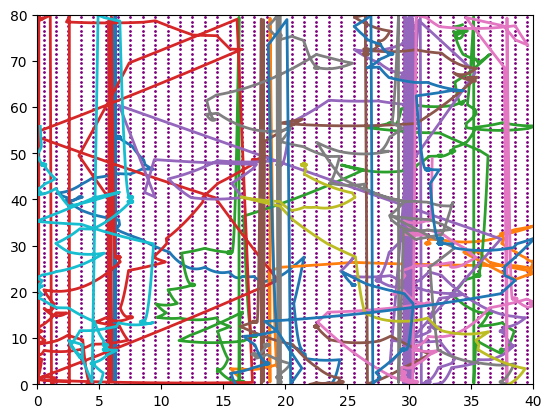

In [9]:
fig, ax = plt.subplots()
plt.xlim([0, grid_x])
plt.ylim([0, grid_y])

lines = []
X_data = []
Y_data = []

drawing = run_sim(np.array([0.0, 1]))


for e in range(len(drawing)):
    i = drawing[e]
    if (e%300 == 0):
        line, = ax.plot([], [], lw=2)
        lines.append(line)
        X_data.append(i.x)
        Y_data.append(i.y)

def update(num, X_data, Y_data, lines):
    for i, line in enumerate(lines):
        line.set_data(X_data[i][:num], Y_data[i][:num])
    return lines

length = max([len(i.x) for i in drawing])

print(length)

plt.scatter(x, y, color='purple', s=1)
ani = animation.FuncAnimation(fig, update, frames=frames, 
                              fargs=(X_data, Y_data, lines), interval=100, blit=True)

writervideo = animation.FFMpegWriter(fps=100)
ani.save("animation.mp4", writer=writervideo)

plt.show()

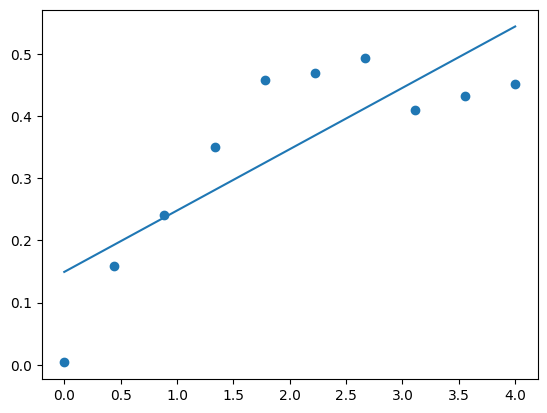

In [ ]:
thing1 = scipy.stats.linregress(accs1,vs1)
plt.scatter(accs1, vs1)
plt.plot(np.linspace(0.0, 4a.0, 10), np.linspace(0.0, 4.0, 10) * thing1.slope + thing1.intercept)

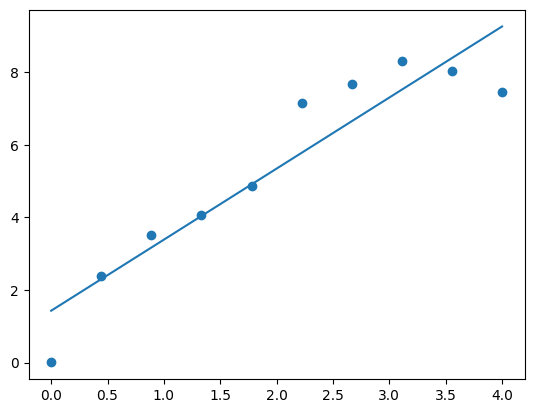

NameError: name 'accs2' is not defined

In [ ]:
thing2 = scipy.stats.linregress(accs2,vs2)
plt.scatter(accs2, vs2)
plt.plot(np.linspace(0.0, 4.0, 10), np.linspace(0.0, 4.0, 10) * thing2.slope + thing2.intercept)

In [14]:
thing1 = scipy.stats.linregress(accs1,vs1)
plt.scatter(accs1, vs1)
plt.plot(np.linspace(0.0, 4.0, 21), np.linspace(0.0, 4.0, 21) * thing1.slope + thing1.intercept)

ValueError: Inputs must not be empty.

In [16]:
modified_vs1

[]